In [173]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)
from pandas.plotting import autocorrelation_plot

import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
#import requests
import zipfile

#import gc

!python --version


#pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)

numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
Python 3.7.4


In [174]:
# original data files
data_dir = './data/'
data_zip = './data_zip/'

In [175]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print('unziped!')

downloading file .zip ...

  0%|                                               | 0.00/19.5k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 19.5k/19.5k [00:00<00:00, 491kB/s]

download finished!

unziped!


In [176]:
import os

#from datetime import date
#date_today = str(date.today())

if not os.path.exists(data_zip):
    os.mkdir(data_zip)
    print("Directory " , data_zip ,  " Created ")
else:    
    print("Directory " , data_zip ,  " already exists")
    
os.rename("./corona-virus-brazil.zip", data_zip+"corona-virus-brazil.zip")

Directory  ./data_zip/  already exists


In [177]:
print("Files:")
!ls {data_dir}

Files:
brazil_covid19.csv     dataset.csv
brazil_covid19_old.csv validation.csv


In [178]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 2754 rows and 5 columns

Last information in 2020-05-10


In [179]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-01-30,Centro-Oeste,Distrito Federal,0,0
1,2020-01-30,Centro-Oeste,Goiás,0,0
2,2020-01-30,Centro-Oeste,Mato Grosso,0,0
3,2020-01-30,Centro-Oeste,Mato Grosso do Sul,0,0
4,2020-01-30,Nordeste,Alagoas,0,0


In [180]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2754 entries, 0 to 2753
Data columns (total 5 columns):
date      2754 non-null object
region    2754 non-null object
state     2754 non-null object
cases     2754 non-null int64
deaths    2754 non-null int64
dtypes: int64(2), object(3)
memory usage: 107.7+ KB


In [181]:
df = covid_br[covid_br["state"] == "Amazonas"]

df.tail(5)

,date,region,state,cases,deaths
2634,2020-05-06,Norte,Amazonas,9243,751
2661,2020-05-07,Norte,Amazonas,10099,806
2688,2020-05-08,Norte,Amazonas,10727,874
2715,2020-05-09,Norte,Amazonas,11925,962
2742,2020-05-10,Norte,Amazonas,12599,1004


In [182]:
df.shape

(102, 5)

In [183]:
df.describe()

,cases,deaths
count,102.000000,102.000000
mean,1445.127451,112.745098
std,2808.275482,227.923154
min,0.000000,0.000000
25%,0.000000,0.000000
50%,7.000000,0.000000
75%,1536.500000,102.000000
max,12599.000000,1004.000000


### Feature Engineering

In [184]:
# datetime

df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df.set_index('date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2020-01-30 to 2020-05-10
Data columns (total 5 columns):
region         102 non-null object
state          102 non-null object
cases          102 non-null int64
deaths         102 non-null int64
day_of_week    102 non-null object
dtypes: int64(2), object(3)
memory usage: 4.8+ KB


In [185]:
# creating month and day

df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 


df.head()

,region,state,cases,deaths,day_of_week,month,day
date,,,,,,,
2020-01-30,Norte,Amazonas,0,0,Thursday,1,30
2020-01-31,Norte,Amazonas,0,0,Friday,1,31
2020-02-01,Norte,Amazonas,0,0,Saturday,2,1
2020-02-02,Norte,Amazonas,0,0,Sunday,2,2
2020-02-03,Norte,Amazonas,0,0,Monday,2,3


In [186]:
# creating death by day
df['deaths_d'] = df['deaths'] - df['deaths'].shift(1)

In [187]:
# deleting "deaths = 0"
df = df[df["deaths"] > 0]
df.shape

(47, 8)

## Test Harness

### Validation Dataset

In [188]:
X = pd.Series(df['deaths_d'])
split_size = round(len(X) * 0.90)
dataset, validation = X[0:split_size], X[split_size:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 

# save
dataset.to_csv(data_dir+'dataset.csv')
validation.to_csv(data_dir+'validation.csv')

Dataset 42, Validation 5


In [189]:
# https://medium.com/@bingobee01/pandas-tricks-and-tips-a7b87c3748ea

## Persistence - Base Line Model

In [191]:
# load data

#X = dataset #.values
X = X.astype('float32')
split_size = 0.70

train_size = round(len(X) * split_size)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=17.000, Expected= 16
>Predicted=16.000, Expected= 31
>Predicted=31.000, Expected= 29
>Predicted=29.000, Expected= 45
>Predicted=45.000, Expected= 51
>Predicted=51.000, Expected= 25
>Predicted=25.000, Expected= 47
>Predicted=47.000, Expected= 36
>Predicted=36.000, Expected= 65
>Predicted=65.000, Expected=102
>Predicted=102.000, Expected= 55
>Predicted=55.000, Expected= 68
>Predicted=68.000, Expected= 88
>Predicted=88.000, Expected= 42
RMSE: 25.223


## Data Analysis

### Components of Time Series

Time series analysis provides a body of techniques to better understand a dataset. Perhaps the most useful of these is the decomposition of a time series into 4 constituent parts:

- Level. The baseline value for the series if it were a straight line.

- Trend. The optional and often linear increasing or decreasing behavior of the series over time.
􏰀
- Seasonality. The optional repeating patterns or cycles of behavior over time.

- Noise. The optional variability in the observations that cannot be explained by the model.


p.11

### Concerns of Forecasting

When forecasting, it is important to understand your goal. Use the Socratic method and ask lots of questions to help zoom in on the specifics of your predictive modeling problem. For example:

1. How much data do you have available and are you able to gather it all together? More data is often more helpful, offering greater opportunity for exploratory data analysis, model testing and tuning, and model fidelity.

2. What is the time horizon of predictions that is required? Short, medium or long term? Shorter time horizons are often easier to predict with higher confidence.

3. Can forecasts be updated frequently over time or must they be made once and remain static? Updating forecasts as new information becomes available often results in more accurate predictions.

4. At what temporal frequency are forecasts required? Often forecasts can be made at a lower or higher frequencies, allowing you to harness down-sampling, and up-sampling of data, which in turn can offer benefits while modeling.


Time series data often requires cleaning, scaling, and even transformation. For example:

- Frequency. Perhaps data is provided at a frequency that is too high to model or is unevenly spaced through time requiring resampling for use in some models.

- Outliers. Perhaps there are corrupt or extreme outlier values that need to be identified and handled.

- Missing. Perhaps there are gaps or missing data that need to be interpolated or imputed.

p.12

______

- Sliding Window, p.15

- Sliding Window With Multivariates, p.16

- Sliding Window With Multiple Steps, p.18

- Lag Features, p.29: X.shift(1)

- Rolling Window Statistics, p.31: rolling(X).mean()

        width = 3
        shifted = temps.shift(width - 1)
        window = shifted.rolling(window=width)
        dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


- Expanding Window Statistics, p.33: expanding()

        temps = DataFrame(series.values)
        window = temps.expanding()
        dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


### Summary Statistics

In [192]:
# Number of Observations
X.shape

(47,)

In [193]:
# Descriptive Statistics
X.describe()

count     47.000000
mean      21.361702
std       23.999479
min        0.000000
25%        3.500000
50%       16.000000
75%       30.000000
max      102.000000
Name: deaths_d, dtype: float64

### Line Plot

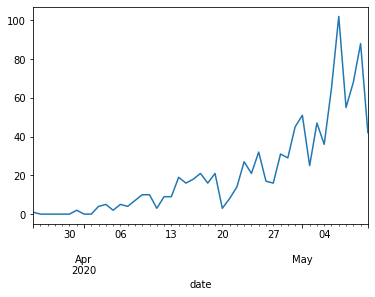

In [194]:
X.plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Histogram and Density Plot

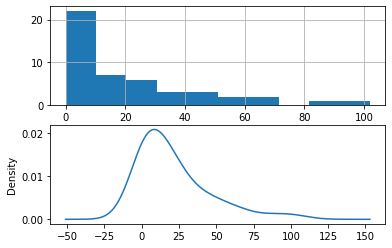

In [195]:
plt.figure(1)
plt.subplot(211)
X.hist()

plt.subplot(212)
X.plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

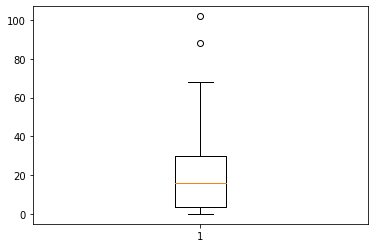

In [196]:
plt.boxplot(X)
plt.show()

- There are outliers on the top.

### Heat Maps

In [232]:
# Analysing correlations
''' 
import seaborn as sns

corr = series.corr()
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.set()
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)

plt.show()
'''

'''
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A')) years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto') 
pyplot.show()
# p.46
'''



"\nseries = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0,\nparse_dates=True, squeeze=True)\ngroups = series.groupby(Grouper(freq='A')) years = DataFrame()\nfor name, group in groups:\n    years[name.year] = group.values\nyears = years.T\npyplot.matshow(years, interpolation=None, aspect='auto') \npyplot.show()\n# p.46\n"

### Lag Scatter Plots

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


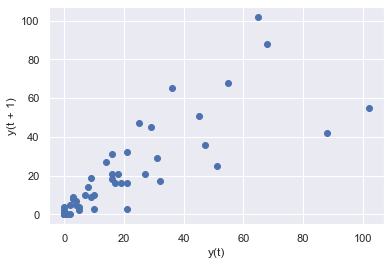

In [235]:
from pandas.plotting import lag_plot
lag_plot(X)
plt.show()

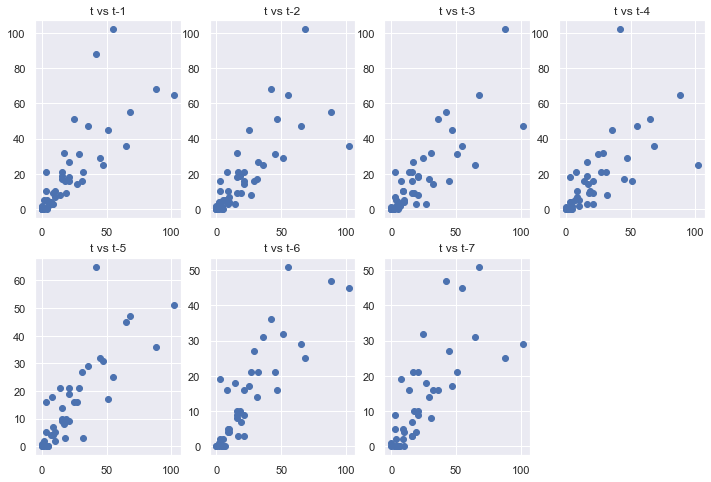

In [249]:
from pandas import concat

lags = 7
columns = [X]

for i in range(1,(lags + 1)):
    columns.append(X.shift(i))

dataframe = concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i)) 

dataframe.columns = columns 
plt.figure(1, figsize=(12, 8))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

### Autocorrelation

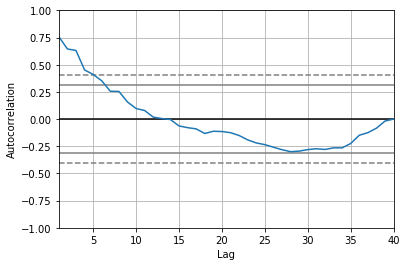

In [38]:
# autocorrelation
autocorrelation_plot(X)
plt.show()

### Resampling

Two types of resampling are:

- Upsampling: Where you increase the frequency of the samples, such as from minutes to seconds.

- Downsampling: Where you decrease the frequency of the samples, such as from days to months.

There are perhaps two main reasons why you may be interested in resampling your time series data:

- 􏰀Problem Framing: Resampling may be required if your data is available at the same frequency that you want to make predictions.

- Feature Engineering: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

p.53

In [256]:
df.head(2)

,region,state,cases,deaths,day_of_week,month,day,deaths_d
date,,,,,,,,
2020-03-25,Norte,Amazonas,54,1,Wednesday,3,25,1.0
2020-03-26,Norte,Amazonas,67,1,Thursday,3,26,0.0


In [257]:
# visualize downsampling to "week" mean

week_mean = df["deaths_d"].resample('W', level=0).mean()
week_mean

date
2020-03-29     0.200000
2020-04-05     1.857143
2020-04-12     6.857143
2020-04-19    17.142857
2020-04-26    17.428571
2020-05-03    34.857143
2020-05-10    65.142857
Freq: W-SUN, Name: deaths_d, dtype: float64

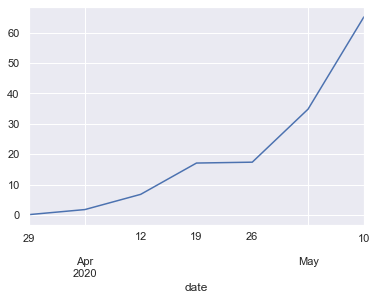

In [258]:
week_mean.plot() 
plt.show()

In [259]:
# week sum

week_sum = df["deaths_d"].resample('W', level=0).sum()
week_sum

date
2020-03-29      1.0
2020-04-05     13.0
2020-04-12     48.0
2020-04-19    120.0
2020-04-26    122.0
2020-05-03    244.0
2020-05-10    456.0
Freq: W-SUN, Name: deaths_d, dtype: float64

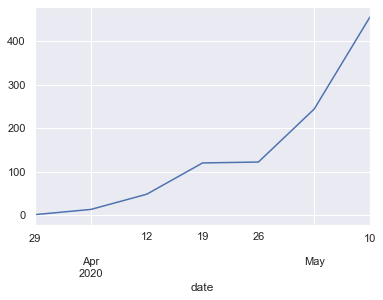

In [260]:
week_sum.plot() 
plt.show()

## ARIMA Models

In [41]:
from statsmodels.tsa.arima_model import ARIMA

- there are high correlations before day 3.

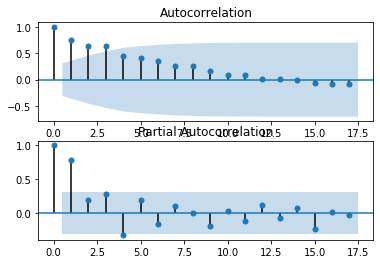

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
plt.show()

In [46]:
# ARIMA
p = 4   # Autocorrelation Function (ACF)

d = 1   # level of differencing

q = 0   # Partial Autocorrelation Function (PACF)

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.deaths_d   No. Observations:                   39
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -160.387
Method:                       css-mle   S.D. of innovations      266056241.395
Date:                Mon, 11 May 2020   AIC                            332.775
Time:                        14:42:56   BIC                            342.756
Sample:                             1   HQIC                           336.356
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9293        nan        nan        nan         nan         nan
ar.L1.D.deaths_d    -0.5224        nan        nan        nan         nan         nan
ar.L2.D.deaths_d    -0.5272 

/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/maxfc/Anac

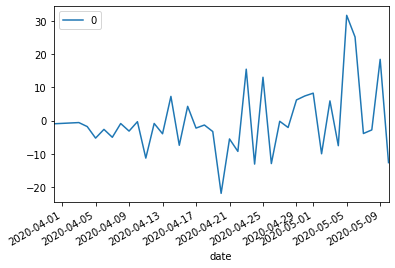

               0
count  39.000000
mean   -0.217554
std    10.538477
min   -21.860070
25%    -5.362082
50%    -2.040795
75%     5.141770
max    31.705800


In [47]:
# fit model
model = ARIMA(X, order=(p,d,q))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals residuals.plot(kind='kde') 
plt.show()

# summary stats of residuals
print(residuals.describe())

### Grid Search ARIMA Hyperparameters

In [49]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order): # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
             for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

warnings.filterwarnings("ignore")

evaluate_models(dataset, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=35.374
ARIMA(0, 0, 1) RMSE=28.540
ARIMA(0, 0, 2) RMSE=23.546
ARIMA(0, 0, 3) RMSE=22.526
ARIMA(0, 1, 0) RMSE=19.342
ARIMA(0, 1, 1) RMSE=22.017
ARIMA(0, 1, 2) RMSE=21.228
ARIMA(0, 2, 0) RMSE=27.238
ARIMA(0, 2, 1) RMSE=19.335
ARIMA(1, 0, 0) RMSE=21.660
ARIMA(1, 1, 0) RMSE=20.608
ARIMA(1, 1, 1) RMSE=22.625
ARIMA(1, 2, 0) RMSE=21.875
ARIMA(1, 2, 1) RMSE=20.256
ARIMA(2, 0, 0) RMSE=22.465
ARIMA(2, 1, 0) RMSE=21.261
ARIMA(2, 1, 1) RMSE=23.745
ARIMA(2, 2, 0) RMSE=21.175
ARIMA(2, 2, 1) RMSE=20.943
ARIMA(3, 0, 0) RMSE=23.175
ARIMA(3, 1, 0) RMSE=22.444
ARIMA(3, 1, 1) RMSE=22.802
ARIMA(3, 2, 0) RMSE=22.035
ARIMA(3, 2, 1) RMSE=21.920
ARIMA(3, 2, 2) RMSE=21.200
ARIMA(4, 0, 0) RMSE=24.114
ARIMA(4, 1, 0) RMSE=18.624
ARIMA(4, 1, 1) RMSE=19.297
ARIMA(4, 2, 0) RMSE=20.395
ARIMA(4, 2, 1) RMSE=17.320
Best ARIMA(4, 2, 1) RMSE=17.320


### Moving Average as Data Preparation

In [177]:
X = pd.Series(df['deaths_d'])
rolling = X.rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

date
2020-03-25         NaN
2020-03-31         NaN
2020-04-03    2.333333
2020-04-04    3.666667
2020-04-05    3.666667
2020-04-06    4.000000
2020-04-07    3.666667
2020-04-08    5.333333
2020-04-09    7.000000
2020-04-10    9.000000
Name: deaths_d, dtype: float64


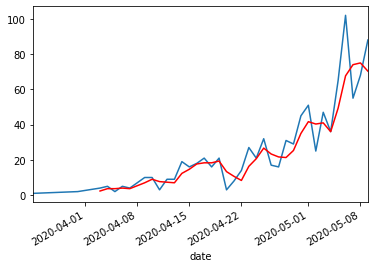

In [178]:
# plot original and transformed dataset 
X.plot() 
rolling_mean.plot(color='red') 
plt.show()

### Moving Average as Feature Engineering

predicted=2.333333, expected=5.000000
predicted=3.666667, expected=2.000000
predicted=3.666667, expected=5.000000
predicted=4.000000, expected=4.000000
predicted=3.666667, expected=7.000000
predicted=5.333333, expected=10.000000
predicted=7.000000, expected=10.000000
predicted=9.000000, expected=3.000000
predicted=7.666667, expected=9.000000
predicted=7.333333, expected=9.000000
predicted=7.000000, expected=19.000000
predicted=12.333333, expected=16.000000
predicted=14.666667, expected=18.000000
predicted=17.666667, expected=21.000000
predicted=18.333333, expected=16.000000
predicted=18.333333, expected=21.000000
predicted=19.333333, expected=3.000000
predicted=13.333333, expected=8.000000
predicted=10.666667, expected=14.000000
predicted=8.333333, expected=27.000000
predicted=16.333333, expected=21.000000
predicted=20.666667, expected=32.000000
predicted=26.666667, expected=17.000000
predicted=23.333333, expected=16.000000
predicted=21.666667, expected=31.000000
predicted=21.333333, e

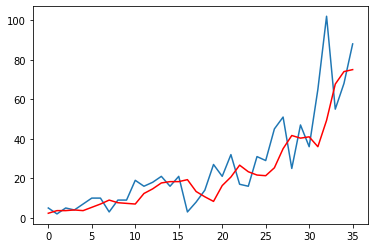

In [176]:


# prepare situation
#X = deaths.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

### Is your Time Series White Noise?

In [179]:
X.describe()

# mean is not zero
# standard deviation is high

count     39.000000
mean      24.666667
std       24.305439
min        1.000000
25%        7.500000
50%       17.000000
75%       31.500000
max      102.000000
Name: deaths_d, dtype: float64

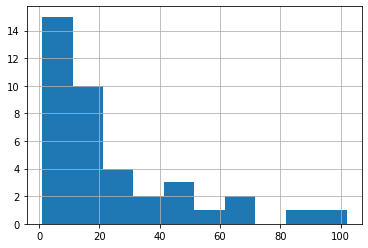

In [180]:
# histogram plot
X.hist()
plt.show()

# histogram is not a bell curve.

### Check Stationarity

In [141]:
from statsmodels.tsa.stattools import adfuller

In [181]:
# statistical test

# The null hypothesis of the test is that the time series is non-stationary.
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test

result = adfuller(X) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.836204
p-value: 1.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


### Time Series Components

Systematic Components:
- Level
- Trend
- Seasonality

Nos-Systematic Component:
- Noise


### Automatic Time Series Decomposition

### Additive Decomposition

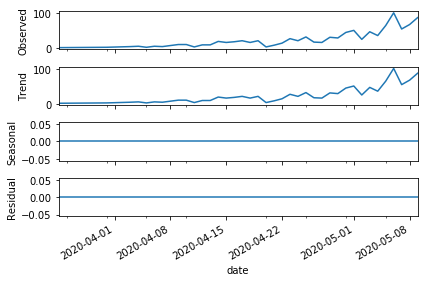

In [182]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(X, model='additive', freq=1) 
result.plot()
plt.show()

### Multiplicative Decomposition

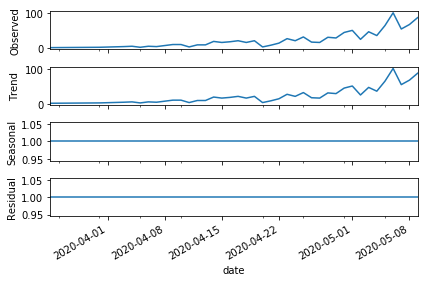

In [183]:
result = seasonal_decompose(X, model='multiplicative', freq=1) 
result.plot()
plt.show()

### Log transformation

In [184]:
result = adfuller(np.log(X)) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.718514
p-value: 0.421600
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


### Detrend by Model Fitting

In [186]:
??????


from sklearn.linear_model import LinearRegression

# fit linear model
X = [i for i in range(0, len(X))]
X = np.reshape(X, (len(X), 1))
y = dataset.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(deaths))]

# plot detrended
plt.plot(detrended)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [39, 35]

In [147]:
detrended

[147.08846153846162,
 127.24979757085028,
 109.41113360323894,
 92.57246963562758,
 72.73380566801625,
 55.895141700404906,
 38.05647773279355,
 23.21781376518223,
 11.379149797570875,
 -0.4595141700404781,
 -19.298178137651803,
 -32.136842105263156,
 -44.97550607287451,
 -47.81417004048586,
 -53.65283400809716,
 -57.49149797570851,
 -58.330161943319865,
 -64.16882591093122,
 -65.00748987854257,
 -83.84615384615387,
 -97.68481781376522,
 -105.52348178137657,
 -100.36214574898793,
 -101.20080971659928,
 -91.03947368421063,
 -95.87813765182193,
 -101.71680161943334,
 -92.55546558704464,
 -85.39412955465593,
 -62.23279352226734,
 -33.07145748987864,
 -29.91012145749005,
 -4.748785425101346,
 9.412550607287358,
 52.57388663967595,
 132.73522267206465,
 165.89655870445324,
 212.05789473684194,
 278.21923076923065]

In [148]:
result = adfuller(detrended) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.971563
p-value: 0.993957
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
